**Group Names**: Michael Jakober, Cyril Winkler, Jaron Matzinger, Maurice Salzmann

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Binary Classification

Here, we use a tabular dataset from kaggle (https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset) with features on patients physical spine details possibly suited for classifying whether the person is 'abnormal' or 'normal' - possibly suffers back pain or not.   

We here just want to see how the training works with logistic regression (binary case). We set aside a proper handling of the learning experiment by splitting the data into a train and test partition (in general we would even have a validation partition). We focus here on making the system learn something. 

1. Download the dataset from kaggle (see the link in the notebook). Load it into a pandas dataframe (see the code in the notebook). Normalise the data.
2. Complete the code for the implementation of the methods \verb|predict|, \verb|cost|, \verb|gradient_cost|, \verb|accuracy|. As a test, just invoke the method by suitable dummy values.
3. Implement (full) batch GD for minimizing the CE cost (without autograd). Plot cost vs the number of epochs.
4. Implement (full) batch GD for minimizing the CE cost, this time with autograd. show that you obtain consistent results.
5. Tune the learning rate. What is a reasonable learning rate?

### 1. Load Data

In [2]:
df = pd.read_csv("./data/Dataset_spine.csv") # possibly modify!
df = df.drop(columns=['Unnamed: 13'])
N  = df.shape[0]
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


#### Normalization and Turning into Torch Tensors

In [3]:
x0 = torch.from_numpy(df.values[:,0:-1].astype(np.float64))
X = (x0 - torch.mean(x0, dim=0)) / torch.std(x0, dim=0)
Y = torch.tensor(('Abnormal' == df.values[:,-1])).int().reshape(-1,1)
print(X.shape, Y.shape)

torch.Size([310, 12]) torch.Size([310, 1])


### 2. Implement the Model for (Binary) Logistic Regression

Data:  $\,\qquad X = \left(\begin{array}{cccc} 1 & X_{11} & \dots & X_{1n} \\ \vdots & \vdots & \vdots & \vdots \\ 1 & X_{N1} & \dots & X_{Nn}\end{array}\right)\qquad$ and $\qquad Y = \left(\begin{array}{c} Y_{1} \\ \vdots \\ Y_{N} \end{array}\right)$

Model: $\qquad\hat{Y}(X;W) = \sigma\left(X W^\intercal\right) \qquad$ where $\qquad W = \left(\begin{array}{c} W_0 \\ W_1 \\ \vdots \\ W_n \end{array}\right)$

The model outputs the probability of observing in a sample $x$ a '1' (Abnormal).

Cost:  $\,\qquad C(W) = -\frac{1}{N}\sum_j \left(Y_j\log(\hat{Y}_j(X;W)) + (1-Y_j)\log(1-\hat{Y}_j(X;W))\right)$

__Remark:__ Note that the logarithm diverges at arguments approaching 0. Make sure that you don't run into numerical issues.

In [4]:
# compose torch tensors X of shape (N,13) by inserting a column with 1's as first column  
X = torch.cat((torch.ones(N,1),X), dim=1)

In [5]:
# implement methods for predicting the probability of having label 0 or 1 (W with shape (1,13))
def predict(X, W):
    # YOUR CODE (START)
    return torch.sigmoid(X @ W.T)
    # YOUR CODE (END)

def cost(X,Y,W):
    # YOUR CODE (START)
    Y_hat = predict(X, W)
    eps = 1e-9
    Y_hat = torch.clamp(Y_hat, eps, 1 - eps) # Avoid log(0) loss
    return - torch.mean(Y * torch.log(Y_hat) + (1 - Y) * torch.log(1 - Y_hat))
    # YOUR CODE (END)

In [6]:
def gradient_cost(X,Y,W):
    # YOUR CODE (START)
    Y_hat = predict(X, W)
    return ((Y_hat - Y).T @ X / X.shape[0])
    # YOUR CODE (END)
    
def accuracy(Y,Yhat):
    # YOUR CODE (START)
    Y_pred = (Yhat >= 0.5).double() # Convert probabilities to 0 or 1
    return torch.mean((Y_pred == Y).double()).item()
    # YOUR CODE (END)

Just for testing:

In [7]:
W = torch.randn((1,13), dtype=torch.double)
print(predict(X[0],W))
print(cost(X,Y,W))
print(gradient_cost(X,Y,W))
print(accuracy(Y,predict(X,W)))

tensor([0.0316], dtype=torch.float64)
tensor(2.1864, dtype=torch.float64)
tensor([[-0.3217, -0.3293, -0.2138, -0.3135, -0.2634,  0.1654, -0.3336, -0.0530,
         -0.0714, -0.1501, -0.2170,  0.0637, -0.0298]], dtype=torch.float64)
0.3580645161290323


### 3. Implement Full Batch Gradient Descent

Training Accuracy (max,end): 0.867742, 0.854839
Training Cost (end): 0.284127


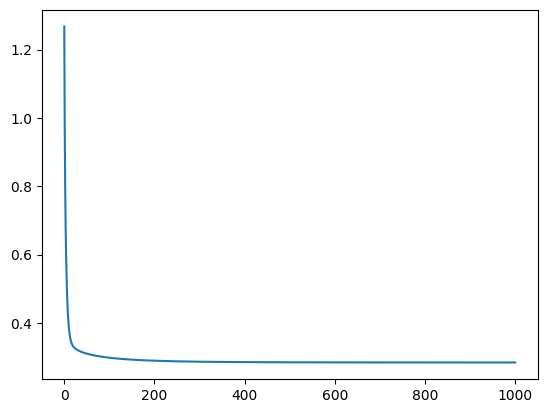

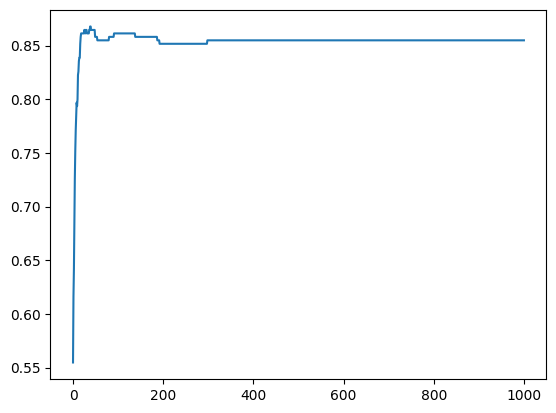

In [8]:
# adjust if needed
nepochs = 1000
lr = 1.0

## initial parameter
W = torch.randn((1,13), dtype=torch.double)

# track the costs
costs = [cost(X, Y, W)]
accs = [accuracy(Y, predict(X, W))]

# YOUR CODE (START)

# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for _ in range(nepochs):
    grad = gradient_cost(X, Y, W)
    W -= lr * grad
    costs.append(cost(X, Y, W))
    accs.append(accuracy(Y, predict(X, W)))

# YOUR CODE (END)
    
# some output
accs = np.array(accs)

print("Training Accuracy (max,end): %f, %f"%(np.max(accs), accs[-1]))
print("Training Cost (end): %f"%costs[-1].item())
plt.figure(1)
plt.plot(range(nepochs+1), costs)
plt.figure(2)
plt.plot(range(nepochs+1), accs)

### 4. Implement Full Batch Gradient Descent with PyTorch's autograd

100%|██████████| 1000/1000 [00:00<00:00, 7836.69it/s]

Training Accuracy (max, end): 0.8677, 0.8548
Training Cost (end): 0.2841


<function matplotlib.pyplot.show(close=None, block=None)>

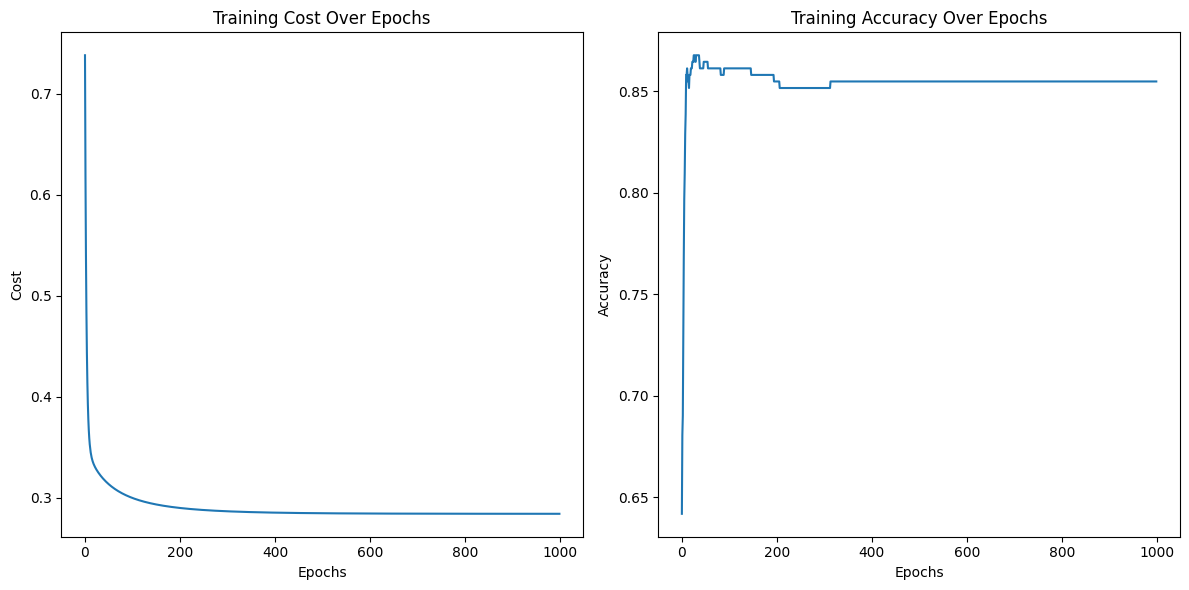

In [9]:
import tqdm

torch.manual_seed(42)

n_epochs = 1000
lr = 1.0

W = torch.randn((1,13), dtype=torch.double, requires_grad=True)

costs = []
accs = []

for _ in tqdm.tqdm(range(n_epochs)):
    # Forward pass: Compute predictions
    Y_hat = predict(X, W)
    # Compute cost using binary cross-entropy
    loss = cost(X, Y, W)
    # Compute accuracy
    acc = accuracy(Y, Y_hat)
    # Store metrics
    costs.append(loss.item())
    accs.append(acc)
    # Backpropagation: Compute gradients
    loss.backward()
    # Gradient Descent step (update W)
    with torch.no_grad():
        W -= lr * W.grad
        W.grad.zero_()

# Convert accuracy list to NumPy array
accs = np.array(accs)

print(f'Training Accuracy (max, end): {np.max(accs):.4f}, {accs[-1]:.4f}')
print(f'Training Cost (end): {costs[-1]:.4f}')

fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout='tight')

axs[0].plot(range(nepochs), costs)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Cost')
axs[0].set_title('Training Cost Over Epochs')

axs[1].plot(range(nepochs), accs)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy Over Epochs')

plt.show

### 5. Tune Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.

- The most efficient learning rate is probably 1
- From 5 upwards the costs starts to jump but still works
- I dunno